# Applying ViT Transfer Learning for QR Classification:

- Pre-Trained Vision Transformer: **google/vit-base-patch-224**
- Dataset: **PhiUSIIL Phishing URL Dataset**

## Imports and Login:

In [49]:
import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

from huggingface_hub import notebook_login
from datasets import Dataset
from transformers import AutoImageProcessor, ViTForImageClassification
from datasets import Image as HFImage
from PIL import Image

from transformers import TrainingArguments, Trainer
import evaluate

In [50]:
notebook_login()

## Loading and Preparing Dataset:

In [63]:
qr_images_path = r"qr_codes\qr_images\qr_images"
qr_labels_path = r"qr_codes\qr_labels.csv"

In [65]:
def get_all_qr_paths(filepath: str) -> list:
    """
    Takes in the path to the directory holding all QR images, and return the image file paths as a list
    
    Args:
        filepath: The path to the directory holding the QR images
        
    Returns:
        list: A list holding full paths to QR image files
    """
    
    # Defining sorting helper function
    def extract_number(filename: str) -> int:
        """
        Extracts the ID or number corresponding to the QR image
        
        Args:
            filename: The QR image
            
        Returns:
            int: The ID or number corresponding to the QR image
        """
        image_number = int(filename.split("_")[1].split(".")[0])
        return image_number
    
    # Extracting all items from provided path
    all_items = os.listdir(filepath)
    
    # Keeping only the files from the list
    all_files = [f for f in all_items if os.path.isfile(os.path.join(filepath, f))]
    
    # Numerically sorting the files
    sorted_files = sorted(all_files, key=extract_number)
    
    # Returns full paths so downstream code can open files correctly
    full_paths = [os.path.join(filepath, f) for f in sorted_files]
    return full_paths

In [66]:
# Configuring paths to all QR images
image_paths = get_all_qr_paths(qr_images_path)

In [67]:
print("QR Image Path Example:", image_paths[0])

QR Image Path Example: qr_codes\qr_images\qr_images\img_0.png


In [55]:
def get_labels(filepath: str, return_as_list: bool=False) -> pd.DataFrame | list:
    """
    Reads the provided labels into a Pandas DataFrame or a list
    
    Args:
        filepath: The path containing the datasets labels
        return_as_list: Determines whether the labels should be returned as a list (defaults to False)
        
    Returns:
        pd.DataFrame: Returns a DataFrame with the the IDs as the index
    """
    labels = pd.read_csv(filepath, index_col=0)
    
    if return_as_list:
        labels = labels["label"].tolist()
        
    return labels

In [56]:
# Extracting the labels
y_labels = get_labels(qr_labels_path, return_as_list=True)

In [57]:
print("Labels of first 5 QR Images:", y_labels[:5])

Labels of first 5 QR Images: [1, 1, 1, 1, 1]


In [58]:
def create_lazy_list(qr_images: list, data_labels: list) -> Dataset:
    """
    Creates a dataset concatenating the QR code paths and their corresponding labels.
    
    Args:
        qr_images: A list containin the full path to each QR image in the dataset
        data_labels: A list containing the labels for each QR image
        
    Returns:
        Dataset: A lazy list Dataset
    """
    dataset = Dataset.from_dict({"image": qr_images, "label": data_labels})
    dataset = dataset.cast_column("image", HFImage())
    
    return dataset

In [59]:
# Creating a complete dataset
dataset = create_lazy_list(image_paths, y_labels)

Record 0 QR Image:


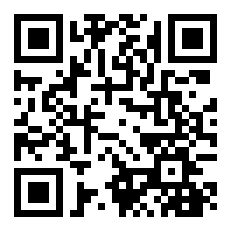

Record 0 Label: 1


In [60]:
# Retrieving first QR code in dataset
record_0 = dataset[0]
print("Record 0 QR Image:")
display(record_0["image"])
print("Record 0 Label:", record_0["label"])

### Train Val Test Split

In [ ]:
dataset_split = dataset.train_test_split(
    test_size=0.2,
    #stratify_by_column="label",
    seed=42
    )

train_dataset = dataset_split["train"]
test_dataset = dataset_split["test"]

## Preprocessing:

In [ ]:
# Load image processor
""" 
Prepares input features for vision models and post processing their outputs by 
    transformations such as resizing, normalization, and conversion to PyTorch 
    and Numpy tensors.
"""
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
processor

label2id = ... # Fill in with dataset

In [ ]:
def transforms(batch):
    """
    Transforms raw images to pixel_values and passes through labels.
    """
    # 1. Convert images to RGB. 
    # dataset.cast_column("image", HFImage()) already decoded them to PIL, 
    # so we just ensure they are RGB.
    images = [x.convert("RGB") for x in batch["image"]]

    # Process images using the ViT processor
    inputs = processor(images, return_tensors="pt")
    inputs["labels"] = batch["label"]
    
    return inputs


def collate_fn(batch):
    """
    This function takes a list of inputs dictionaries (from transforms) and stacks them into batch tensors.
    """
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
# This applies the preprocessing on-the-fly when data is loaded
train_dataset.set_transform(transforms)
test_dataset.set_transform(transforms)

## Evaluation Metrics

In [ ]:
"""
Compute evaluation metrics for model predictions using the Hugging Face
    `evaluate` library.
"""
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

## Model

In [ ]:
# Model initialization
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels = 2,
    id2label = {0: "Phishing", 1: "Benign"},
    label2id = {"Phishing": 0, "Benign": 1}, 
    ignore_mismatched_sizes=True
)   

### Freezing layers

In [ ]:
# Freeze 85,827,109 params
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

num_params = sum([p.numel() for p in model.parameters()])

trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

### Training

In [ ]:
# Define training arguments and train
training_args = TrainingArguments(
    output_dir="./vit-base-qr-classifier",
    per_device_train_batch_size=16,
    #evaluation_strategy="epoch",
    #save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=.0001,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='none',
    #load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor
)

trainer.train()

## Model Evaluation

In [ ]:
trainer.evaluate(...)